# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output

from tqdm import tqdm
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        nbPath = pathlib.Path.cwd()
        RepoPath = nbPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        import params
        mouse_defs = params.mouse_defs
        defs = mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root
        reload(dt)
        reload(defs)
        reload(params)
    finally:
        os.chdir(nbPath)
    
    
    %run "S1-mouse-M1-decoding.ipynb"
    
    print('Done!')

Done!


# Part 1

functions that plot each panel.


In [2]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

---

In [3]:
@utility.report
def plot_m1_decoding(ax, AllDFs):
    defs = mouse_defs
    
    #=========================
    within_score = {}
    aligned_score = {}
    unaligned_score = {}
    for i, df1 in enumerate(tqdm(AllDFs)):
        animal1 = df1.mouse[0]

        AllData, AllVel = defs.get_data_array_and_vel([df1], defs.exec_epoch_decode, area=defs.areas[0],
                                                    n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]
        *_,n_time,n_comp = AllData.shape
        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        # resizing
        X1 = AllData1.reshape((-1, n_time, n_comp))
        AllVel1 = AllVel1.reshape((-1,n_time,3))

        fold_score =[]
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(X1[:,0,0]):
            x_train, x_test = X1[train_index,...], X1[test_index,...]
            y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

            lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model.fit(x_train=x_train, y_train=y_train, epochs = 10)
            lstm_model.predict(x_test, y_test)
            fold_score.append(lstm_model.score)
        fold_score = np.median(fold_score)
        within_score[df1.file[0]] = fold_score


        aligned_score[df1.file[0]] = {}
        unaligned_score[df1.file[0]] = {}
        for j, df2 in enumerate(AllDFs):
            if j < i: continue
            animal2 = df2.mouse[0]
            if animal1 == animal2: continue
            
            #================================
            # Across sesisons
            AllData, AllVel = defs.get_data_array_and_vel([df1, df2], defs.exec_epoch_decode,
                                                          area=defs.areas[0], n_components=defs.n_components)

            # adding history
            AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
            AllData = AllData[...,defs.MAX_HISTORY:,:]
            AllVel = AllVel[...,defs.MAX_HISTORY:,:]
            AllData1 = AllData[0,...]
            AllData2 = AllData[1,...]
            AllVel1 = AllVel[0,...]
            AllVel2 = AllVel[1,...]
            # resizing
            _,n_trial,n_time,n_comp = AllData1.shape
            X1 = AllData1.reshape((-1,n_comp))
            X2 = AllData2.reshape((-1,n_comp))
            AllVel1 = AllVel1.reshape((-1,n_time,3))
            AllVel2 = AllVel2.reshape((-1,n_time,3))
            
            #================================
            # Aligned
            *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
            U = U.reshape((-1,n_time,n_comp))
            V = V.reshape((-1,n_time,n_comp))
            X1 = X1.reshape((-1,n_time,n_comp))
            X2 = X2.reshape((-1,n_time,n_comp))

            lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=3)
            lstm_model.fit(x_train=U, y_train=AllVel1)
            lstm_model.predict(V, AllVel2)
            aligned_score[df1.file[0]][df2.file[0]] = lstm_model.score.mean()

            #================================
            # Unaligned
            lstm_model1 = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model1.fit(x_train=X1, y_train=AllVel1)
            lstm_model1.predict(X2, AllVel2)
            lstm_model2 = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=3)
            lstm_model2.fit(x_train=X2, y_train=AllVel2)
            lstm_model2.predict(X1, AllVel1)

            unaligned_score[df1.file[0]][df2.file[0]] = (lstm_model1.score.mean() + lstm_model2.score.mean()) / 2


    # return within_score, aligned_score, unaligned_score
    #======================== PLOTTING
    pop_within = np.array(list(within_score.values()))
    pop_aligned = np.array([val for key in aligned_score for val in aligned_score[key].values()])
    pop_unaligned = np.array([val for key in unaligned_score for val in unaligned_score[key].values()])

    ax.errorbar(1, pop_aligned.mean(), np.std(pop_aligned), label='Across\n' r'(\textit{aligned})',
                color=params.colors.MainCC, fmt='-o', capsize=1.5)    
    ax.errorbar(0, pop_unaligned.mean(), np.std(pop_unaligned), label='Across\n' r'(\textit{unaligned})',
                color=params.colors.LowerCC, fmt='-o', capsize=1.5)
    ax.errorbar(2, pop_within.mean(), np.std(pop_within), label='Within',
                color=params.colors.UpperCC, fmt='-o', capsize=1.5)

    unal_vals = []
    al_vals = []
    wi_vals = []
    for file1, nested_dict in aligned_score.items():
        wi_val1 = within_score[file1]
        for file2, al_val in nested_dict.items():
            wi_val2 = within_score[file2]
            unal_val = unaligned_score[file1][file2]
            ax.plot([0,1,2], [unal_val, al_val, wi_val1],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)
            ax.plot([1,2], [al_val, wi_val2],
                    color='gray', lw=.2, zorder=6, marker = 'o', ms=.1, alpha=.2)
            #for stats
            unal_vals.append(unal_val)
            al_vals.append(al_val)
            wi_vals.append(wi_val1)
            wi_vals.append(wi_val2)

    ax.set_xlim([-0.2,2.2])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Across\n' r'(\textit{unaligned})',
                        'Across\n' r'(\textit{aligned})',
                        'Within'])
    ax.set_ylabel('Prediction accuracy ($R^2$)')
    ax.set_ylim([-.05,.85])
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,2])
    ax.spines['left'].set_bounds([0,.8])

    #stats ############################
    #calc stats
    ##for paired stats
    compare_upper_stats = stats.wilcoxon(np.repeat(al_vals,2), wi_vals)
    compare_lower_stats = stats.wilcoxon(al_vals, unal_vals)

    print("Across vs within:", compare_upper_stats)
    print("Across vs control:", compare_lower_stats)

    #annotate stats
    if params.annotate_stats:
        ymin, ymax = ax.get_ylim()
        liney = ymax*0.95
        texty = ymax*1
        line_kwargs = dict(linewidth = 0.5, color = 'k')
        text_kwargs = dict(ha='center', va='center')

        ax.plot([0,1], [liney, liney], **line_kwargs)
        ax.plot([1,2], [liney, liney], linestyle = '--', **line_kwargs)
        
        ax.text(0.5, texty, dt.get_signif_annot(compare_upper_stats[1]), **text_kwargs)
        ax.text(1.5, texty, dt.get_signif_annot(compare_lower_stats[1]), **text_kwargs)

    return within_score, aligned_score, unaligned_score

Executed: `get_full_mouse_data` in 1.9s


100%|█████████████████████████████████████████████| 6/6 [09:54<00:00, 99.10s/it]

Across vs within: WilcoxonResult(statistic=0.0, pvalue=2.9802322387695312e-08)
Across vs control: WilcoxonResult(statistic=3.0, pvalue=0.001220703125)
Executed: `plot_m1_decoding` in 594.6s


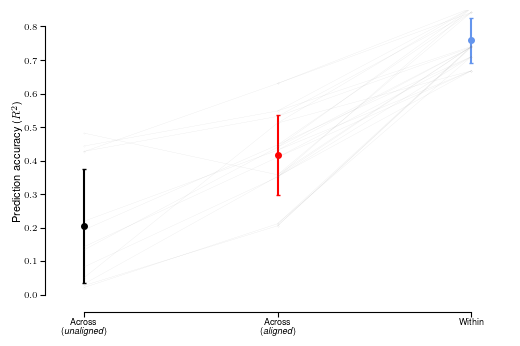

In [4]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    allDFs_M1, _ = get_full_mouse_data()
    
    wi_val, al_val, un_val = plot_m1_decoding(ax, allDFs_M1)
    # plt.savefig(('dummy.pdf'))
    plt.show()

# Part 2

Plot figure

Executed: `get_full_mouse_data` in 0.9s


100%|█████████████████████████████████████████████| 6/6 [07:47<00:00, 77.93s/it]


Across vs within: WilcoxonResult(statistic=0.0, pvalue=2.9802322387695312e-08)
Across vs control: WilcoxonResult(statistic=3.0, pvalue=0.001220703125)
Executed: `plot_m1_decoding` in 467.6s


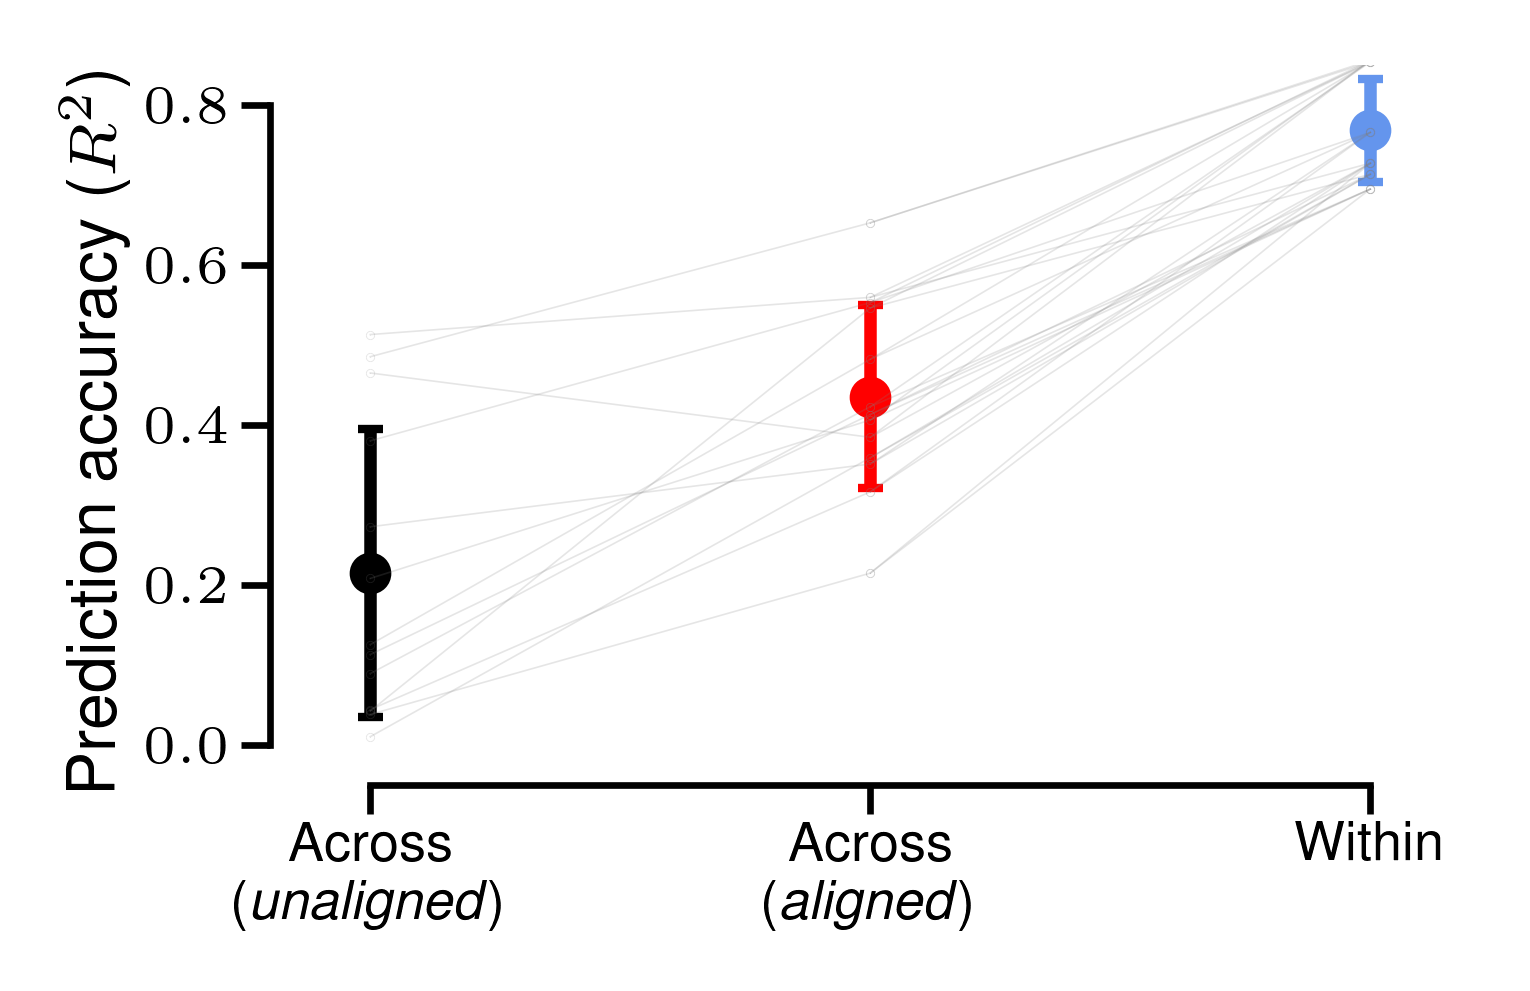

In [5]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize= params.panels.decoding_hist
    fig=plt.figure(figsize=figsize)
    
   
    
    ##########################################
    # 1: Decoding for mouse M1
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=figsize[0],
                                    right=figsize[1],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax1 = fig.add_subplot(gs1[0])

       
    allDFs_M1, _ = get_full_mouse_data()
    
    plot_m1_decoding(ax1, allDFs_M1)

    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     AXES=(ax1,ax2,ax3,ax4,ax5,ax6)
#     OFFX=np.array([.02]*len(AXES))
#     OFFY=np.array([.03]*len(AXES))
#     # OFFX[[-1]]=0.12
#     # OFFX[[1]]=0.06
    
#     params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figureS1-mouse-M1-decoding.pdf', format='pdf', bbox_inches='tight')